## W pdfs

In [1]:
from scipy import ndimage, interpolate
import pyart
from netCDF4 import Dataset
import numpy as np
from datetime import datetime, timedelta
import glob
from copy import deepcopy
from matplotlib import pyplot as plt
import math
%matplotlib inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119 


In [2]:
def area_anal(pixel_area, rr_x, rain_rates): 
    A_rainrate = np.zeros(rr_x.shape) 
    N_rainrate = np.zeros(rr_x.shape) 
    Rm_rainrate = np.zeros(rr_x.shape) 
    for i in range(len(rr_x)): 
        b_fld = np.zeros(rain_rates.shape) 
        b_fld[rain_rates > rr_x[i]] = 1.0 
        regions, N_rainrate[i] = ndimage.label(b_fld) 
        try: 
            A_rainrate[i] = (len(np.where( regions > 0.5)[0]) * pixel_area) 
            Rm_rainrate[i] = rain_rates[ np.where(regions > 0.5)].mean() 
        except IndexError: 
            A_rainrate[i] = 0.0 
            Rm_rainrate[i] = 0.0 
    return N_rainrate, A_rainrate, Rm_rainrate

In [17]:
data_path = '/home/rjackson/usb_drive/multidop_grids/'
wrf_file_list = ['/home/rjackson/satoshi_runs/twp1a/wrfout_d01_2006-01-20_00:00:00',
                 '/home/rjackson/satoshi_runs/twp1b/wrfout_d01_2006-01-20_00:00:00',
                 '/home/rjackson/satoshi_runs/twp2a/wrfout_d01_2006-01-20_00:00:00',
                 '/home/rjackson/satoshi_runs/twp2b/wrfout_d01_2006-01-20_00:00:00']
wrf_run_names = ['twp1a', 'twp1b', 'twp2a', 'twp2b']
conv_strat_path = '/home/rjackson/usb_drive/conv_stratiform/'

# get_radar_times
#     start_year = Start year of animation
#     start_month = Start month of animation
#     start_day = Start day of animation
#     start_hour = Start hour of animation
#     end_year = End year of animation
#     end_month = End month of animation
#     end_day = End day of animation
#     end_minute = End minute of animation
#     minute_interval = Interval in minutes between scans (default is 5)
# This procedure acquires an array of Radar classes between start_time and end_time  
def get_dda_times(start_year, start_month, start_day,
                  start_hour, start_minute, end_year,
                  end_month, end_day, end_hour, 
                  end_minute, minute_interval=5):

    start_time = datetime(start_year,
                      start_month,
                      start_day,
                      start_hour,
                      start_minute,
                      )
    end_time = datetime(end_year,
                      end_month,
                      end_day,
                      end_hour,
                      end_minute,
                      )

    deltatime = end_time - start_time


    if(deltatime.seconds > 0 or deltatime.minute > 0):
        no_days = deltatime.days + 1
    else:
        no_days = deltatime.days
    
    if(start_day != end_day):
        no_days = no_days + 1
        
    days = np.arange(0, no_days, 1)
    print('We are about to load grid files for ' + str(no_days) + ' days')
    

    # Find the list of files for each day
    cur_time = start_time
 
    file_list = []
    time_list = []
    for i in days:
        year_str = "%04d" % cur_time.year
        day_str = "%02d" % cur_time.day
        month_str = "%02d" % cur_time.month
        format_str = (data_path +
                      'cf_compliant_grid' +
                      year_str +
                      month_str +
                      day_str +
                      '*.nc')
    
    
        print('Looking for files with format ' + format_str)
          
        data_list = glob.glob(format_str)
        
        for j in range(0, len(data_list)):
            file_list.append(data_list[j])
        cur_time = cur_time + timedelta(days=1)
    
    
    # Parse all of the dates and time in the interval and add them to the time list
    past_time = []
    for file_name in file_list:
        date_str = file_name[-15:-3]
        year_str = date_str[0:4]
        month_str = date_str[4:6]
        day_str = date_str[6:8]
        hour_str = date_str[8:10]
        minute_str = date_str[10:12]
        second_str = '00'
             
        cur_time = datetime(int(year_str),
                            int(month_str),
                            int(day_str),
                            int(hour_str),
                            int(minute_str),
                            0)
        time_list.append(cur_time)
        
    
    # Sort time list and make sure time are at least xx min apart
    time_list.sort()
    time_list_sorted = deepcopy(time_list)
   
    time_list_final = []
    past_time = []
   
    for times in time_list_sorted:         
        cur_time = times  
        
        if(past_time == []):
            past_time = cur_time
            
        if(cur_time - past_time >= timedelta(minutes=minute_interval)
           and cur_time >= start_time and cur_time <= end_time):
            
            time_list_final.append(cur_time)
            past_time = cur_time
                           
    return time_list_final

# Get a Radar object given a time period in the CPOL dataset
def get_grid_from_dda(time):
    year_str = "%04d" % time.year
    month_str = "%02d" % time.month
    day_str = "%02d" % time.day
    hour_str = "%02d" % time.hour
    minute_str = "%02d" % time.minute
    second_str = "%02d" % time.second
    file_name_str = (data_path +
                    'cf_compliant_grid' +
                     year_str +
                     month_str +
                     day_str +
                     hour_str +
                     minute_str + '.nc')
    
    radar = pyart.io.read_grid(file_name_str)
    return radar

def get_bca(grid):
    berr_origin = [-12960.1,-23091.1]
    x,y = np.meshgrid(grid.x['data'], grid.y['data'])
    a = np.sqrt(np.multiply(x,x)+np.multiply(y,y))
    b = np.sqrt(pow(x-berr_origin[0],2)+pow(y-berr_origin[1],2))
    c = np.sqrt(berr_origin[0]*berr_origin[0]+berr_origin[1]*berr_origin[1])
    theta_1 = np.arccos(x/a)
    theta_2 = np.arccos((x-berr_origin[1])/b)
    return np.arccos((a*a+b*b-c*c)/(2*a*b))

In [4]:
times = get_dda_times(2006, 1, 20, 0, 1,
                      2006, 1, 20, 3, 2)

We are about to load grid files for 1 days
Looking for files with format /home/rjackson/usb_drive/multidop_grids/cf_compliant_grid20060120*.nc


In [21]:
reflectivity_bins = np.arange(0,60,5)
w_bins = np.arange(0,50,5)

N_ref = np.zeros((len(times),len(reflectivity_bins)))
A_ref = np.zeros((len(times),len(reflectivity_bins)))
Z_ref = np.zeros((len(times),len(reflectivity_bins)))
Mean_ref = np.zeros(len(times))

N_w = np.zeros((len(times),len(w_bins)))
A_w = np.zeros((len(times),len(w_bins)))
Z_w = np.zeros((len(times),len(w_bins)))
Mean_w = np.zeros(len(times))

N_refwrf = np.zeros((len(times),len(reflectivity_bins)))
A_refwrf = np.zeros((len(times),len(reflectivity_bins)))
Z_refwrf = np.zeros((len(times),len(reflectivity_bins)))
Mean_refwrf = np.zeros(len(times))

N_wwrf = np.zeros((len(times),len(w_bins)))
A_wwrf = np.zeros((len(times),len(w_bins)))
Z_wwrf = np.zeros((len(times),len(w_bins)))
wrf_radars = []

Mean_wwrf = np.zeros(len(times))
w_level = 5
i = 0
Z_wrf = []

W_wrf = []
PH_wrf = []
PHB_wrf = []
ETA_wrf = []
P_wrf = []
alt_wrf = []
i = 0
for wrf_file in wrf_file_list:
    wrf_cdf = Dataset(wrf_file, mode='r')
    Z_wrf.append(wrf_cdf.variables['REFL_10CM'][:,:,:,:])
    W_wrf.append(wrf_cdf.variables['W'][:])
    PH_wrf.append(wrf_cdf.variables['PH'][:])
    PHB_wrf.append(wrf_cdf.variables['PHB'][:])
    ETA_wrf.append(wrf_cdf.variables['ZNW'][:])
    P_wrf.append(wrf_cdf.variables['PB'][:])
    alt_wrfs = np.zeros(PH_wrf[i].shape)
    # Calculate height from WRF
    array_shape = PH_wrf[i].shape
    alt_wrfs = (PH_wrf[i]+PHB_wrf[i])/9.81
    alt_wrf.append(alt_wrfs)
    wrf_cdf.close()
    i = i + 1

[     0.            101.5826416     203.07717896    304.52639771
    405.94271851    507.31546021    608.63793945    709.90716553
    811.13098145    912.26837158   1013.29925537   1114.21484375
   1215.02307129   1315.73486328   1416.35571289   1516.88513184
   1617.34399414   1736.60522461   1874.67089844   2031.5255127
   2207.140625     2401.52685547   2614.69946289   2846.61499023
   3097.29785156   3347.85864258   3598.34936523   3848.77392578
   4099.12011719   4349.3671875    4599.71582031   4850.44921875
   5101.30810547   5352.06542969   5602.7109375    5853.234375
   6103.56347656   6353.80029297   6603.9453125    6853.98535156
   7103.88330078   7353.68603516   7603.29589844   7852.60351562
   8101.71826172   8350.68847656   8599.52832031   8848.25878906
   9096.89746094   9345.45898438   9593.83984375   9841.95019531
  10089.88085938  10337.70703125  10585.45117188  10833.06640625
  11080.49316406  11327.78222656  11575.05957031  11822.421875
  12069.89746094  12317.456054

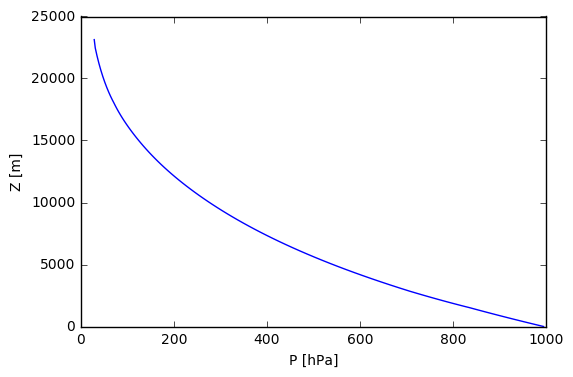

In [22]:
P_mean = np.zeros(array_shape[1])
H_mean = np.zeros(array_shape[1])
for i in range(0, array_shape[1]-1):
    P_mean[i] = np.nanmean(P_wrf[0][:,i,:,:])
    H_mean[i] = np.nanmean(alt_wrf[0][:,i,:,:])
    
P_mean[P_mean == 0] = np.nan
plt.plot(P_mean/1e2, H_mean)
plt.xlabel('P [hPa]')
plt.ylabel('Z [m]')
print(H_mean)

## Generate PDFs from observations

In [7]:
num_levels = 40
ws = np.ma.zeros((len(times), num_levels, 81, 111))
ws_all = np.ma.zeros((len(times), num_levels, 81, 111))
minzs = np.ma.zeros((len(times), num_levels, 81, 111))
maxzs = np.ma.zeros((len(times), num_levels, 81, 111))
Zs = np.ma.zeros((len(times), num_levels, 81, 111))
max_w_individual = []
level_individual = []
label_individual = []
count_individual = []
count = 0
n = 0
for time in times:
    ## Get all continous regions of W > 1 m s-1 in 3D w array
    pyart_grid = get_grid_from_dda(time)
    bca = get_bca(pyart_grid)
    w = pyart_grid.fields['upward_air_velocity']['data']
    Z = pyart_grid.fields['reflectivity']['data']
    w_all = deepcopy(w)
    for levels in range(0,num_levels-1):
        w[levels] = np.ma.masked_where(np.logical_or(np.logical_or(bca < math.pi/6,
                                                                   bca > 5*math.pi/6), 
                                                     w[levels] < 1), w[levels])
        Z[levels] = np.ma.masked_where(np.logical_or(np.logical_or(bca < math.pi/6,
                                                                   bca > 5*math.pi/6), 
                                                     w[levels] < 1), Z[levels])
        w_all[levels] = np.ma.masked_where(np.logical_or(bca < math.pi/6,
                                                         bca > 5*math.pi/6), 
                                                         w_all[levels])

    grid_x = pyart_grid.point_x['data']
    grid_y = pyart_grid.point_y['data']
    grid_z = pyart_grid.point_z['data']
    
    # Set mask to exclude data outside of updrafts
    w_temp = deepcopy(w)
    w_temp[~w_temp.mask] = 1
    w_temp[w_temp.mask] = 0
    w_temp.mask = False

    six_connected_structure = [[[0,0,0],
                                [0,1,0],
                                [0,0,0]],
                               [[0,1,0],
                                [1,1,1],
                                [0,1,0]],
                               [[0,0,0],
                                [0,1,0],
                                [0,0,0]]]

    updrafts, num_updrafts = ndimage.measurements.label(w_temp, 
                                                        structure=six_connected_structure)
    
    # Get statistics in continous regions
    index=np.arange(0, num_updrafts + 1)
    max_z = ndimage.measurements.maximum(grid_z, 
                                         labels=updrafts, 
                                         index=index)
    min_z = ndimage.measurements.minimum(grid_z, 
                                         labels=updrafts,
                                         index=index)
   
    deep_cores = np.where(np.logical_and(max_z >= 15000, min_z <= 1000))
    depth = max_z-min_z

    max_z_olevel = np.ma.zeros((81,111))
    min_z_olevel = np.ma.zeros((81,111))
    max_z_level = np.ma.zeros((num_levels, 81,111))
    min_z_level = np.ma.zeros((num_levels, 81,111))
    
    # Find deep convective cores and get max updraft speeds
    for levels in range(0,num_levels-1):
        label_level = updrafts[levels]
        masked_array = np.ma.zeros(updrafts.shape)
        masked_array.mask = True
        w_temp = w[levels]
        
        for labels in range(1, len(max_z)-1):
            indicies = np.ma.where(label_level == labels)                                
            max_z_olevel[indicies] = max_z[labels]
            min_z_olevel[indicies] = min_z[labels]
            
            if(len(indicies[0]) > 0  
               and max_z[labels] >= 5000
               and min_z[labels] <= 1000):
                max_w_individual.append(max(w_temp[indicies]))
                level_individual.append(levels)
                n = n + 1
                label_individual.append(labels)
                count_individual.append(count)
               
        max_z_level[levels] = max_z_olevel
        min_z_level[levels] = min_z_olevel
        
    ws[count] = w
    ws_all[count] = w_all
    minzs[count] = min_z_level
    maxzs[count] = max_z_level 
    Zs[count] = Z
    count = count + 1


max_w_individual = np.array(max_w_individual)
level_individual = np.array(level_individual)
label_individual = np.array(label_individual)
count_individual = np.array(count_individual)
updraft_nos = np.zeros(len(count_individual))
updraft_count = 0
for counts in range(0, max(count_individual)):
    labels = label_individual[count_individual == counts]
    for i in np.unique(labels):
        updraft_nos[np.logical_and(count_individual == counts,
                                   label_individual == i)] = updraft_count
        updraft_count = updraft_count + 1
    
print(str(len(max_w_individual[level_individual == 1])) + ' DCCs found')

# Calculate PDF
mean_w = np.ma.zeros(num_levels)
median_w = np.ma.zeros(num_levels)
max_w = np.ma.zeros(num_levels)
mean_z = np.ma.zeros(num_levels)
median_z = np.ma.zeros(num_levels)
max_z = np.ma.zeros(num_levels)
ninety_w = np.ma.zeros(num_levels)
ninety_five_w = np.ma.zeros(num_levels)
ninety_nine_w = np.ma.zeros(num_levels)
bins = np.arange(0,40,1)
bins_z = np.arange(0,60,1)
h_bins = np.arange(0, 20000, 500)
w_hist = np.ma.zeros((num_levels, len(bins)-1))
w_hist_all = np.ma.zeros((num_levels, len(bins)-1))
dims = ws.shape
total_counts = 0
# Make p.d.f.s 
print(num_levels)
updraft_no = 2
for levels in range(0,num_levels):
    w_level = ws[:,levels,:,:]
    z_level = Zs[:,levels,:,:]
    minz_level = minzs[:,levels,:,:]
    maxz_level = maxzs[:,levels,:,:]
    
    ws_in_core = w_level[~w_level.mask]
    minzs_in_core = minz_level[~w_level.mask]
    maxzs_in_core = maxz_level[~w_level.mask]
    max_w_level = ndimage.measurements.maximum(w[levels],
                                               labels=updrafts[levels],
                                               index=index)
    
    mean_w[levels] = np.ma.mean(max_w_individual[level_individual == levels])
    median_w[levels] = np.ma.median(max_w_individual[level_individual == levels])

    counts, b = np.histogram(ws_in_core, bins=bins)    
    w_hist[levels] = counts

    counts, b = np.histogram(w_level, bins=bins)
    w_hist_all[levels] = counts 
    
    total_counts = total_counts + sum(counts)
    if(len(ws_in_core) > 0):
        ninety_w[levels] = np.percentile(max_w_individual[level_individual == levels], 90)
        ninety_five_w[levels] = np.percentile(max_w_individual[level_individual == levels], 95)
        ninety_nine_w[levels] = np.percentile(max_w_individual[level_individual == levels], 99)
    else:
        ninety_five_w[levels] = float('nan')
        ninety_nine_w[levels] = float('nan')
        ninety_w[levels] = float('nan')

/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:141: RuntimeWarning: invalid value encountered in true_divide
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:142: RuntimeWarning: invalid value encountered in arccos
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:143: RuntimeWarning: invalid value encountered in true_divide
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in less
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in greater
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: RuntimeWarning: invalid value encountered in less
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:25: RuntimeWarning: invalid value encountered in greater
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.

40 DCCs found
40


/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## Generate PDFs from WRF model run

In [27]:
height = np.zeros(array_shape[1:])
num_levels = array_shape[1]
mean_w_wrf = np.ma.zeros((len(wrf_file_list),num_levels))
median_w_wrf = np.ma.zeros((len(wrf_file_list),num_levels))
max_w_wrf = np.ma.zeros((len(wrf_file_list),num_levels))
height_level = np.ma.zeros((len(wrf_file_list),num_levels))
ninety_w_wrf = np.ma.zeros((len(wrf_file_list),num_levels))
ninety_five_w_wrf = np.ma.zeros((len(wrf_file_list),num_levels))
ninety_nine_w_wrf = np.ma.zeros((len(wrf_file_list),num_levels))
w_hist = np.ma.zeros((len(wrf_file_list), 
                      num_levels, 
                      len(bins)-1))
w_hist_all = np.ma.zeros((len(wrf_file_list), 
                          num_levels, 
                          len(bins)-1))
for j in range(0, len(wrf_file_list)):
    max_w_individual = []
    level_individual = []
    label_individual = []
    count_individual = []
    height_individual = []
    for i in range(0, array_shape[0]):
        ## Get all continous regions of W > 1 m s-1 in 3D w array
        w = np.ma.array(W_wrf[j][i])
    
        w_all = deepcopy(w)
        for levels in range(0,array_shape[1]):
            w[levels] = np.ma.masked_where(w[levels] < 1, w[levels])
            w_all[levels] = W_wrf[j][i,levels]
            height[levels] = alt_wrf[j][i,levels]
        

        grid_z = height
    
        # Set mask to exclude data outside of updrafts
        w_temp = deepcopy(w)
        w_temp[~w_temp.mask] = 1
        w_temp[w_temp.mask] = 0
        w_temp.mask = False

        six_connected_structure = [[[0,0,0],
                                    [0,1,0],
                                    [0,0,0]],
                                   [[0,1,0],
                                    [1,1,1],
                                    [0,1,0]],
                                   [[0,0,0],
                                    [0,1,0],
                                    [0,0,0]]]

        updrafts, num_updrafts = ndimage.measurements.label(w_temp, 
                                                            structure=six_connected_structure)
    
        # Get statistics in continous regions
        index=np.arange(0, num_updrafts + 1)
        max_z = ndimage.measurements.maximum(grid_z, 
                                             labels=updrafts, 
                                             index=index)
        min_z = ndimage.measurements.minimum(grid_z, 
                                             labels=updrafts,
                                             index=index)
        deep_cores = np.where(np.logical_and(max_z >= 15000, min_z <= 1000))
        depth = max_z-min_z
        max_z_olevel = np.ma.zeros((array_shape[2],
                                    array_shape[3]))
        min_z_olevel = np.ma.zeros((array_shape[2],
                                    array_shape[3]))
        max_z_level = np.ma.zeros((array_shape[1],
                                   array_shape[2],
                                   array_shape[3]))
        min_z_level = np.ma.zeros((array_shape[1],
                                   array_shape[2],
                                   array_shape[3]))
    
        # Find deep convective cores and get max updraft speeds
        for levels in range(0,array_shape[1]):
            label_level = updrafts[levels]
            masked_array = np.ma.zeros(updrafts.shape)
            masked_array.mask = True
            w_temp = w[levels]
            height_temp = height[levels]
            for labels in range(1, len(max_z)-1):
                indicies = np.ma.where(label_level == labels)                                
                max_z_olevel[indicies] = max_z[labels]
                min_z_olevel[indicies] = min_z[labels]
            
                if(len(indicies[0]) > 0  
                   and max_z[labels] >= 5000
                   and min_z[labels] <= 1000):
                    max_w_individual.append(max(w_temp[indicies]))
                    level_individual.append(levels)
                    n = n + 1
                    label_individual.append(labels)
                    count_individual.append(count)
                    height_individual.append(np.mean(height_temp[indicies]))
               
            max_z_level[levels] = max_z_olevel
            min_z_level[levels] = min_z_olevel
        
        count = count + 1

    max_w_individual = np.array(max_w_individual)
    level_individual = np.array(level_individual)
    label_individual = np.array(label_individual)
    count_individual = np.array(count_individual)
    height_individual = np.array(height_individual)
    updraft_nos = np.zeros(len(count_individual))
    updraft_count = 0
    print(count_individual)
    for counts in range(0, max(count_individual)):
        labels = label_individual[count_individual == counts]
        for i in np.unique(labels):
            updraft_nos[np.logical_and(count_individual == counts,
                                       label_individual == i)] = updraft_count
            updraft_count = updraft_count + 1
    
    print(str(len(max_w_individual[level_individual == 1])) + ' DCCs found')

    # Calculate PDF
    
    bins = np.arange(0,40,1)
    bins_z = np.arange(0,60,1)
    h_bins = np.arange(0, 20000, 500)
 
    dims = ws.shape
    total_counts = 0
    # Make p.d.f.s 
    print(num_levels)
    updraft_no = 2
    for levels in range(0,array_shape[1]):
        mean_w_wrf[j,levels] = np.ma.mean(max_w_individual[level_individual == levels])
        median_w_wrf[j,levels] = np.ma.median(max_w_individual[level_individual == levels])
        height_level[j,levels] = np.nanmean(height_individual[level_individual == levels])
        counts, b = np.histogram(ws_in_core, bins=bins)    
        w_hist[j,levels] = counts

        counts, b = np.histogram(w_level, bins=bins)
        w_hist_all[j,levels] = counts 
    
        total_counts = total_counts + sum(counts)
        if(len(np.where(level_individual == levels)) > 0):
            ninety_w_wrf[j,levels] = np.nanpercentile(max_w_individual[level_individual == levels], 90)
            ninety_five_w_wrf[j,levels] = np.nanpercentile(max_w_individual[level_individual == levels], 95)
            ninety_nine_w_wrf[j,levels] = np.nanpercentile(max_w_individual[level_individual == levels], 99)
        else:
            ninety_five_w_wrf[j,levels] = float('nan')
            ninety_nine_w_wrf[j,levels] = float('nan')
            ninety_w_wrf[j,levels] = float('nan')

[ 92  92  92 ..., 109 109 109]
25 DCCs found
97


/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnin

[110 110 110 ..., 127 127 127]
33 DCCs found
97


/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnin

[128 128 128 ..., 145 145 145]
23 DCCs found
97


/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnin

[146 146 146 ..., 163 163 163]
18 DCCs found
97


/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnin

/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:852: RuntimeWarning: invalid value encountered in greater_equal
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)


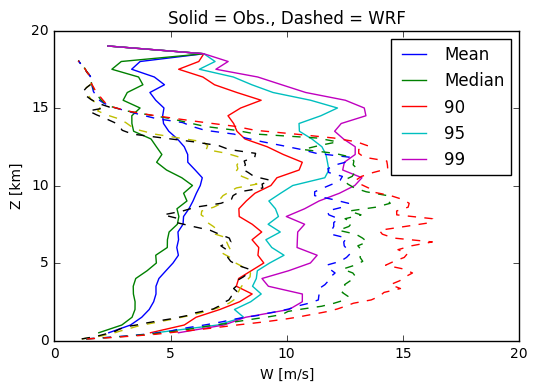

In [9]:
z_levels = np.arange(0,20,0.5)
h1 = plt.plot(mean_w, z_levels, label="Median")
h2 = plt.plot(median_w, z_levels, label="Mean")
h3 = plt.plot(ninety_w, z_levels, label="90")
h4 = plt.plot(ninety_five_w, z_levels, label="95")
h5 = plt.plot(ninety_nine_w, z_levels, label="99")
h6 = plt.plot(mean_w_wrf, height_level/1e3, label="Median WRF", linestyle='--')
h7 = plt.plot(median_w_wrf, height_level/1e3, label="Mean WRF", linestyle='--')
h3 = plt.plot(ninety_w_wrf, height_level/1e3, label="90", linestyle='--')
h4 = plt.plot(ninety_five_w_wrf, height_level/1e3, label="95", linestyle='--')
h5 = plt.plot(ninety_nine_w_wrf, height_level/1e3, label="99", linestyle='--')
plt.legend(['Mean', 'Median', '90','95','99'])
plt.xlabel('W [m/s]')
plt.ylabel('Z [km]')
plt.xlim([0,20])
plt.title('Solid = Obs., Dashed = WRF')

/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:852: RuntimeWarning: invalid value encountered in greater_equal
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)


(0, 30)

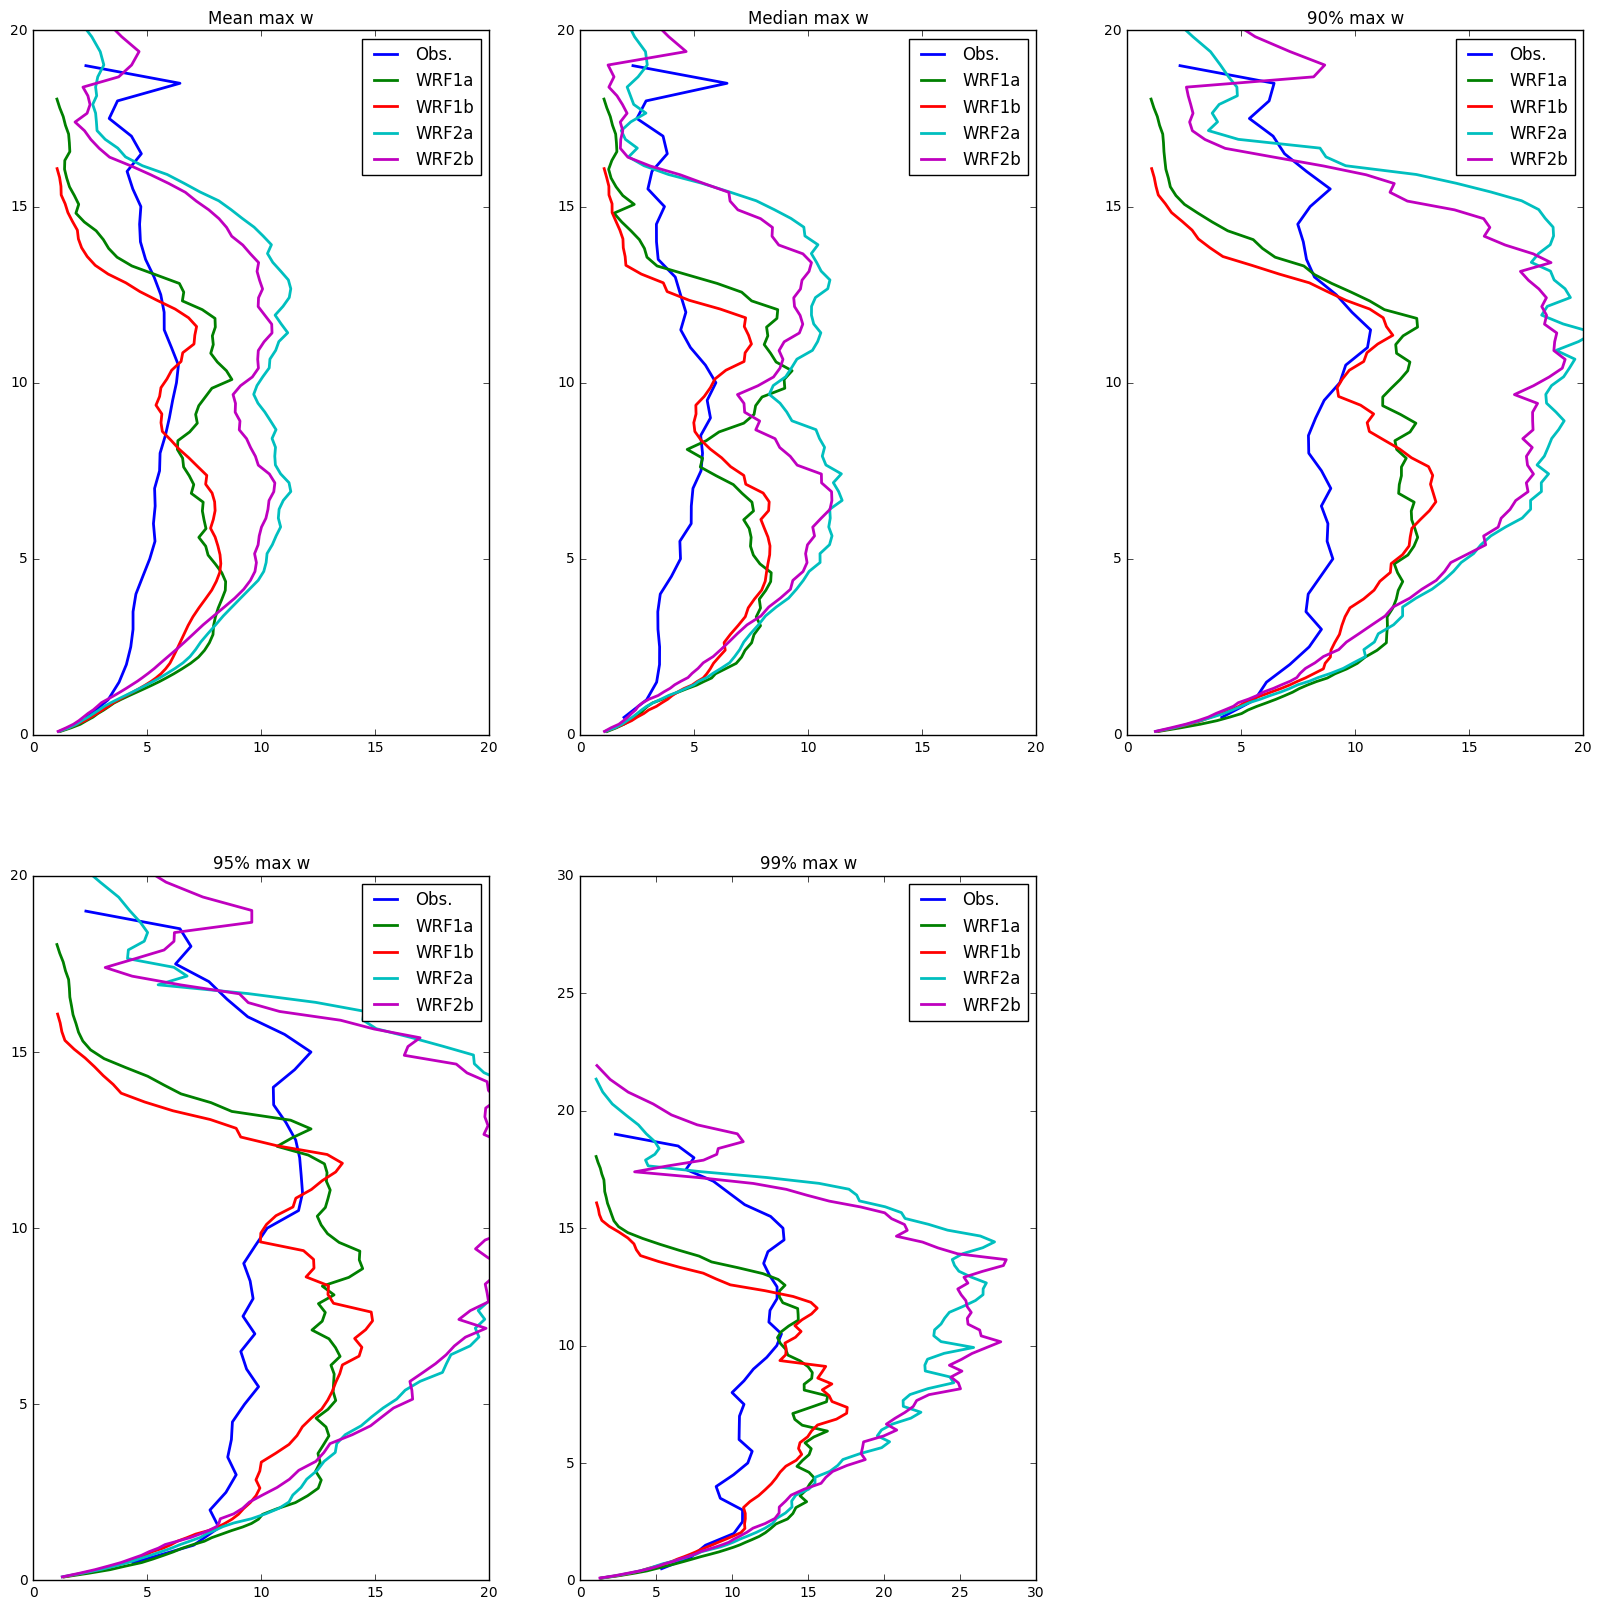

In [37]:
plt.figure(figsize=(20,20))
plt.subplot(231)
plt.title('Mean max w')
h1 = plt.plot(mean_w, z_levels, label="Median", linewidth=2)
h2 = plt.plot(mean_w_wrf[0], height_level[0]/1e3, label="Median WRF", linewidth=2)
h3 = plt.plot(mean_w_wrf[1], height_level[1]/1e3, label="Median WRF", linewidth=2)
h4 = plt.plot(mean_w_wrf[2], height_level[2]/1e3, label="Median WRF", linewidth=2)
h5 = plt.plot(mean_w_wrf[3], height_level[3]/1e3, label="Median WRF", linewidth=2)
plt.legend(['Obs.', 'WRF1a', 'WRF1b', 'WRF2a', 'WRF2b'])
plt.xlim([0, 20])
plt.ylim([0, 20])
plt.subplot(232)
plt.title('Median max w')
h1 = plt.plot(median_w, z_levels, label="Median", linewidth=2)
h2 = plt.plot(median_w_wrf[0], height_level[0]/1e3, label="Median WRF", linewidth=2)
h3 = plt.plot(median_w_wrf[1], height_level[1]/1e3, label="Median WRF", linewidth=2)
h4 = plt.plot(median_w_wrf[2], height_level[2]/1e3, label="Median WRF", linewidth=2)
h5 = plt.plot(median_w_wrf[3], height_level[3]/1e3, label="Median WRF", linewidth=2)
plt.legend(['Obs.', 'WRF1a', 'WRF1b', 'WRF2a', 'WRF2b'])
plt.xlim([0, 20])
plt.ylim([0, 20])
plt.subplot(233)
plt.title('90% max w')
h1 = plt.plot(ninety_w, z_levels, label="Median", linewidth=2)
h2 = plt.plot(ninety_w_wrf[0], height_level[0]/1e3, label="Median WRF", linewidth=2)
h3 = plt.plot(ninety_w_wrf[1], height_level[1]/1e3, label="Median WRF", linewidth=2)
h4 = plt.plot(ninety_w_wrf[2], height_level[2]/1e3, label="Median WRF", linewidth=2)
h5 = plt.plot(ninety_w_wrf[3], height_level[3]/1e3, label="Median WRF", linewidth=2)
plt.legend(['Obs.', 'WRF1a', 'WRF1b', 'WRF2a', 'WRF2b'])
plt.xlim([0, 20])
plt.ylim([0, 20])
plt.subplot(234)
plt.title('95% max w')
h1 = plt.plot(ninety_five_w, z_levels, label="Median", linewidth=2)
h2 = plt.plot(ninety_five_w_wrf[0], height_level[0]/1e3, label="Median WRF", linewidth=2)
h3 = plt.plot(ninety_five_w_wrf[1], height_level[1]/1e3, label="Median WRF", linewidth=2)
h4 = plt.plot(ninety_five_w_wrf[2], height_level[2]/1e3, label="Median WRF", linewidth=2)
h5 = plt.plot(ninety_five_w_wrf[3], height_level[3]/1e3, label="Median WRF", linewidth=2)
plt.legend(['Obs.', 'WRF1a', 'WRF1b', 'WRF2a', 'WRF2b'])
plt.xlim([0, 20])
plt.ylim([0, 20])
plt.subplot(235)
plt.title('99% max w')
h1 = plt.plot(ninety_nine_w, z_levels, label="Median", linewidth=2)
h2 = plt.plot(ninety_nine_w_wrf[0], height_level[0]/1e3, label="Median WRF", linewidth=2)
h3 = plt.plot(ninety_nine_w_wrf[1], height_level[1]/1e3, label="Median WRF", linewidth=2)
h4 = plt.plot(ninety_nine_w_wrf[2], height_level[2]/1e3, label="Median WRF", linewidth=2)
h5 = plt.plot(ninety_nine_w_wrf[3], height_level[3]/1e3, label="Median WRF", linewidth=2)
plt.legend(['Obs.', 'WRF1a', 'WRF1b', 'WRF2a', 'WRF2b'])
plt.xlim([0, 30])
plt.ylim([0, 30])